# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025]AN2DL/Homework2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025]AN2DL/Homework2


## ⚙️ Import Libraries

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


## ⏳ Load the Data

In [3]:
data = np.load("mars_for_students_cleaned.npz")

training_set = data["training_set"]
X_train = training_set[:, 0, :, :]
y_train = training_set[:, 1, :, :]


X_test = data["test_set"]
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

y_train = y_train[..., np.newaxis]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128, 1)
Training y shape: (2505, 64, 128, 1)
Test X shape: (10022, 64, 128, 1)


## 🛠️ Train and Save the Model

In [4]:
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [24]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def load_single_image(image_ind, label, input_size=(64, 128)):

    image = X_train[image_ind]
    label = y_train[image_ind]

    return image, label


class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

    def __getConfi


# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image_path = image
        self.label_path = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = label #apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

        def get_config():
            config = super().get_config()
            config.update({
                "image_path": self.image_path,
                "label_path": self.label_path,
                "frequency": self.frequency,
            })
            return config


SyntaxError: invalid syntax (<ipython-input-24-b06c2676a165>, line 57)

In [6]:
NUM_CLASSES = 5
SEED = 42

from tensorflow.keras.applications import EfficientNetB0

def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=SEED):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model


def unet_with_efficiencynet(input_shape = (64, 128, 1), num_classes = NUM_CLASSES, seed = SEED):
    # Define the input layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    base_model = EfficientNetB0(include_top=False, weights=None, input_tensor=input_layer)

    layer_names = [
        'block1a_activation',  # Equivalent to encoder1
        'block2b_add',         # Equivalent to encoder2
        'block3b_add',         # Equivalent to encoder3
        'block4c_add',         # Equivalent to encoder4
        'block6d_add',         # Equivalent to encoder5
    ]

    # Extract intermediate layers
    layers_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Feature extractor model
    encoder_model = tf.keras.Model(inputs=input_layer, outputs=layers_outputs)

    # Pass the input through the encoder to get feature maps
    encoder_features = encoder_model(input_layer)

    # Bottleneck layer
    bottleneck = unet_block(encoder_features[-1], 128, name='bottleneck')

    # Decoding unet_block
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, encoder_features[-2]])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, encoder_features[-3]])
    u2 = unet_block(u2, 40, name='up_block2_')

    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Concatenate()([u3, encoder_features[-4]])
    u3 = unet_block(u3, 24, name='up_block3_')

    u4 = tfkl.UpSampling2D()(u3)
    u4 = tfkl.Concatenate()([u4, encoder_features[-5]])
    u4 = unet_block(u4, 16, name='up_block4_')

    u5 = tfkl.UpSampling2D()(u4)
    u5 = unet_block(u5, 32, name='up_block5_')

    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation='softmax', name='output_layer')(u5)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet_with_EfficientNet')

    return model



def attention_gate(x, g, filters, kernel_size=3, activation='relu', name=''):
    """
    Mécanisme de porte d'attention pour fusionner les caractéristiques d'entrée.

    :param x: Caractéristiques d'entrée (généralement provenant de la partie encoding).
    :param g: Caractéristiques d'entrée (généralement provenant de la partie decoding).
    :param filters: Nombre de filtres pour les convolutions.
    :param kernel_size: Taille du noyau de la convolution.
    :param activation: Fonction d'activation.
    :param name: Nom de la couche.
    :return: Sortie du mécanisme d'attention.
    """
    # Convolution sur les caractéristiques d'entrée (x) et sur les caractéristiques de "gating" (g)
    f = tfkl.Conv2D(filters, kernel_size, padding='same', activation=activation, name=name + '_f')(x)
    g = tfkl.Conv2D(filters, kernel_size, padding='same', activation=activation, name=name + '_g')(g)

    # Fusion des deux convolutions (ajout ou concaténation)
    h = tfkl.Add()([f, g])  # Ou utilisez une concaténation
    h = tfkl.Activation(activation)(h)

    # Applique une convolution pour affiner l'attention
    attention = tfkl.Conv2D(1, (1, 1), padding='same', activation='sigmoid', name=name + '_attention')(h)

    # Multiplie les caractéristiques avec la carte d'attention
    out = tfkl.Multiply()([x, attention])
    return out

# Exemple d'intégration dans un bloc d'upsampling :
def unet_with_attention(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=SEED):
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    base_model = EfficientNetB0(include_top=False, weights=None, input_tensor=input_layer)

    layer_names = ['block1a_activation', 'block2b_add', 'block3b_add', 'block4c_add', 'block6d_add']
    layers_outputs = [base_model.get_layer(name).output for name in layer_names]
    encoder_model = tf.keras.Model(inputs=input_layer, outputs=layers_outputs)
    encoder_features = encoder_model(input_layer)

    # Bottleneck layer
    bottleneck = unet_block(encoder_features[-1], 128, name='bottleneck')

    # Upsampling path with attention gates
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = attention_gate(u1, encoder_features[-2], 64, name='attention1')
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = attention_gate(u2, encoder_features[-3], 40, name='attention2')
    u2 = unet_block(u2, 40, name='up_block2_')

    u3 = tfkl.UpSampling2D()(u2)
    u3 = attention_gate(u3, encoder_features[-4], 24, name='attention3')
    u3 = unet_block(u3, 24, name='up_block3_')

    u4 = tfkl.UpSampling2D()(u3)
    u4 = attention_gate(u4, encoder_features[-5], 16, name='attention4')
    u4 = unet_block(u4, 16, name='up_block4_')

    u5 = tfkl.UpSampling2D()(u4)
    u5 = unet_block(u5, 32, name='up_block5_')

    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation='softmax', name='output_layer')(u5)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet_with_EfficientNet_and_Attention')
    return model


In [7]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred, smooth=1):
    """
    Dice loss function, ignoring class 0.
    """
    # Convert true labels to one-hot encoding
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=5)  # Assume 5 classes including background

    # Ignore class 0 by slicing the tensor
    y_true_one_hot = y_true_one_hot[..., 1:]  # Exclude the first channel (class 0)
    y_pred = y_pred[..., 1:]  # Exclude the predictions for class 0

    # Flatten the tensors
    y_true_f = K.flatten(y_true_one_hot)
    y_pred_f = K.flatten(y_pred)

    # Compute Dice coefficient
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    dice = (2.0 * intersection + smooth) / (union + smooth)

    return 1.0 - dice

def combined_loss(weight_dice=0.25):
    """
    Combine Dice Loss et Sparse Categorical Cross Entropy.

    :param weight_dice: Poids de la perte Dice dans la combinaison.
    :return: Une fonction de perte personnalisée compatible avec Keras.
    """
    bce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, ignore_class=0)

    def loss_fn(y_true, y_pred):
        """
        Fonction interne pour combiner Dice Loss et BCE.
        """
        # Calcul de la BCE
        loss_bce = bce(y_true, y_pred)

        # Calcul de la Dice Loss
        loss_dice = dice_loss(y_true, y_pred)

        # Combinaison des pertes
        loss_comb = weight_dice * loss_dice + (1 - weight_dice) * loss_bce
        return loss_comb

    return loss_fn


In [8]:
LEARNING_RATE = 1e-3
EPOCHS = 1000
PATIENCE = 25
BATCH_SIZE = 64
SPLITS_SIZE = 0.2

model = unet_with_attention()

from sklearn.model_selection import train_test_split

sX_train, sX_test, sy_train, sy_test = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=SEED
)

train_dataset = tf.data.Dataset.from_tensor_slices((sX_train, sy_train))
train_dataset = train_dataset.batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((sX_test, sy_test))
val_dataset = val_dataset.batch(BATCH_SIZE)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Paramètres de base
initial_learning_rate = LEARNING_RATE  # Taux d'apprentissage initial
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=6*231,  # Nombre d'epochs ou de batches avant que le taux d'apprentissage diminue
    decay_rate=0.84,     # Facteur par lequel le taux d'apprentissage diminue chaque fois
    staircase=True       # Si True, le taux d'apprentissage est mis à jour après chaque étape (et non pas de manière continue)
)

# Création de l'optimiseur avec ce scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


model.compile(
    loss=combined_loss(weight_dice=0.25),
    optimizer=optimizer,
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(0, 0)

Model: "UNet_with_EfficientNet_and_Attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ functional             │ [(None, 32, 64, 32), │    2,911,791 │ input_layer[0][0]   │    Y    │
│ (Functional)           │ (None, 16, 32, 24),  │              │                     │         │
│                        │ (None, 8, 16, 40),   │              │                     │         │
│                        │ (None, 4, 8, 80),    │              │                     │         │
│                        │ (None, 2, 4, 192)]   │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ input_layer       │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ rescaling         │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (Rescaling)            │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ normalization     │ (None, 64, 128, 1)   │            3 │ -                   │    Y    │
│ (Normalization)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ stem_conv_pad     │ (None, 65, 129, 1)   │            0 │ -                   │    -    │
│ (ZeroPadding2D)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ stem_conv         │ (None, 32, 64, 32)   │          288 │ -                   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ stem_bn           │ (None, 32, 64, 32)   │          128 │ -                   │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ stem_activation   │ (None, 32, 64, 32)   │            0 │ -                   │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ block1a_dwconv    │ (None, 32, 64, 32)   │          288 │ -                   │    Y    │
│ (DepthwiseConv2D)      │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ block1a_bn        │ (None, 32, 64, 32)   │          128 │ -                   │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 32, 64, 32)   │            0 │ -                   │    -    │
│ block1a_activation     │                      │              │                     │         │
│ (Activation)         

 Total params: 3,644,648 (13.90 MB)

 Trainable params: 3,609,221 (13.77 MB)

 Non-trainable params: 35,427 (138.39 KB)

Epoch 1/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3032 - loss: 1.3055 - mean_iou: 0.1447  

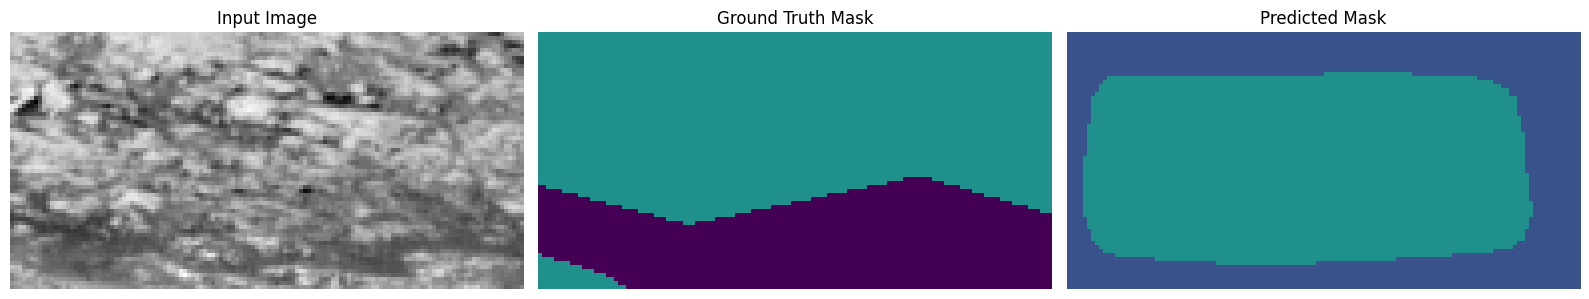

32/32 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.3049 - loss: 1.3012 - mean_iou: 0.1459 - val_accuracy: 0.2619 - val_loss: 1.3320 - val_mean_iou: 0.1253
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.4149 - loss: 0.9105 - mean_iou: 0.2361 - val_accuracy: 0.3473 - val_loss: 1.1858 - val_mean_iou: 0.1151
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.4360 - loss: 0.8223 - mean_iou: 0.2552 - val_accuracy: 0.3473 - val_loss: 1.0851 - val_mean_iou: 0.1151
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.4468 - loss: 0.7934 - mean_iou: 0.2724 - val_accuracy: 0.3473 - val_loss: 1.0598 - val_mean_iou: 0.1151
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.4657 - loss: 0.7517 - mean_iou: 0.3068 - val_accuracy: 0.3473 - val_loss: 1.0551 - val_mean_iou: 0.1151
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.4955 - loss: 0.7099 - mean_iou: 0.3792 

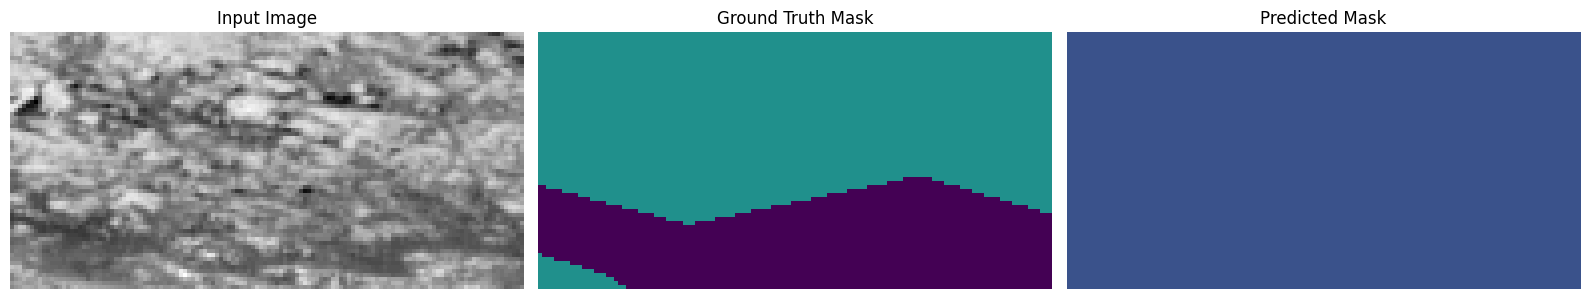

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.4960 - loss: 0.7097 - mean_iou: 0.3795 - val_accuracy: 0.3473 - val_loss: 1.1124 - val_mean_iou: 0.1151
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.5291 - loss: 0.6537 - mean_iou: 0.4160 - val_accuracy: 0.3473 - val_loss: 1.0973 - val_mean_iou: 0.1151
Epoch 8/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.5571 - loss: 0.5894 - mean_iou: 0.4493 - val_accuracy: 0.3473 - val_loss: 1.1310 - val_mean_iou: 0.1151
Epoch 9/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.5732 - loss: 0.5430 - mean_iou: 0.4807 - val_accuracy: 0.3259 - val_loss: 1.1934 - val_mean_iou: 0.1306
Epoch 10/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.5832 - loss: 0.5188 - mean_iou: 0.4947 - val_accuracy: 0.2427 - val_loss: 1.1319 - val_mean_iou: 0.1141
Epoch 11/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6025 - loss: 0.4670 - mean_iou: 0.4819

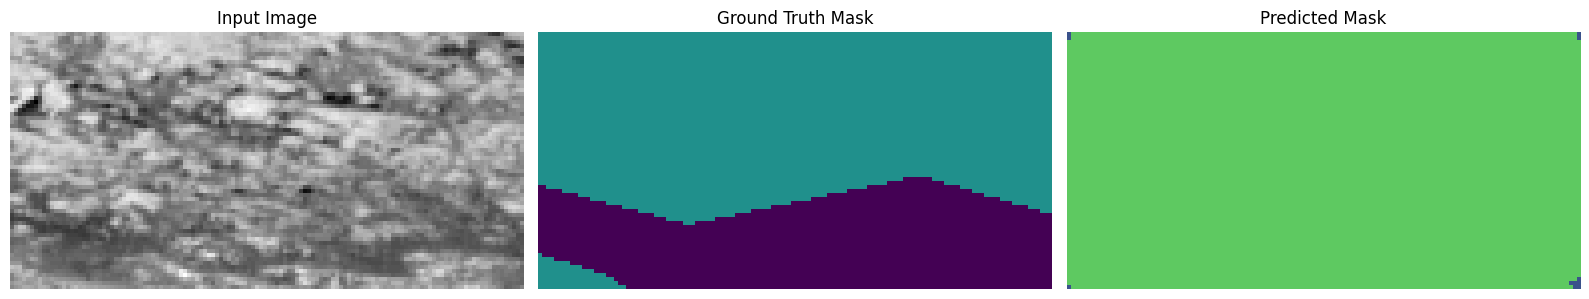

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.6028 - loss: 0.4671 - mean_iou: 0.4797 - val_accuracy: 0.1980 - val_loss: 1.9058 - val_mean_iou: 0.0658
Epoch 12/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.6107 - loss: 0.4486 - mean_iou: 0.4184 - val_accuracy: 0.2012 - val_loss: 1.2927 - val_mean_iou: 0.0706
Epoch 13/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.6122 - loss: 0.4481 - mean_iou: 0.4453 - val_accuracy: 0.3436 - val_loss: 1.0654 - val_mean_iou: 0.1241
Epoch 14/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.6180 - loss: 0.4276 - mean_iou: 0.4533 - val_accuracy: 0.3473 - val_loss: 1.0797 - val_mean_iou: 0.1175
Epoch 15/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.6330 - loss: 0.3886 - mean_iou: 0.5385 - val_accuracy: 0.1980 - val_loss: 1.9245 - val_mean_iou: 0.0658
Epoch 16/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6420 - loss: 0.3700 - mean_iou: 0.4800

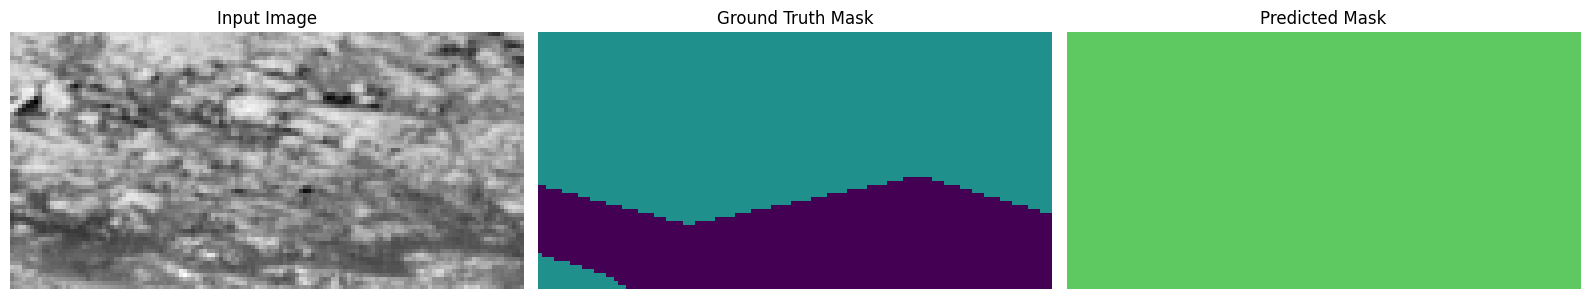

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.6423 - loss: 0.3700 - mean_iou: 0.4792 - val_accuracy: 0.1979 - val_loss: 2.9440 - val_mean_iou: 0.0656
Epoch 17/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.6495 - loss: 0.3603 - mean_iou: 0.5715 - val_accuracy: 0.1979 - val_loss: 2.4176 - val_mean_iou: 0.0656
Epoch 18/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.6595 - loss: 0.3201 - mean_iou: 0.4738 - val_accuracy: 0.1988 - val_loss: 2.4944 - val_mean_iou: 0.0664
Epoch 19/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.6717 - loss: 0.2879 - mean_iou: 0.4900 - val_accuracy: 0.2397 - val_loss: 1.9314 - val_mean_iou: 0.1002
Epoch 20/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.6874 - loss: 0.2512 - mean_iou: 0.6515 - val_accuracy: 0.3065 - val_loss: 1.4764 - val_mean_iou: 0.1725
Epoch 21/1000
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6888 - loss: 0.2322 - mean_iou: 0.6558

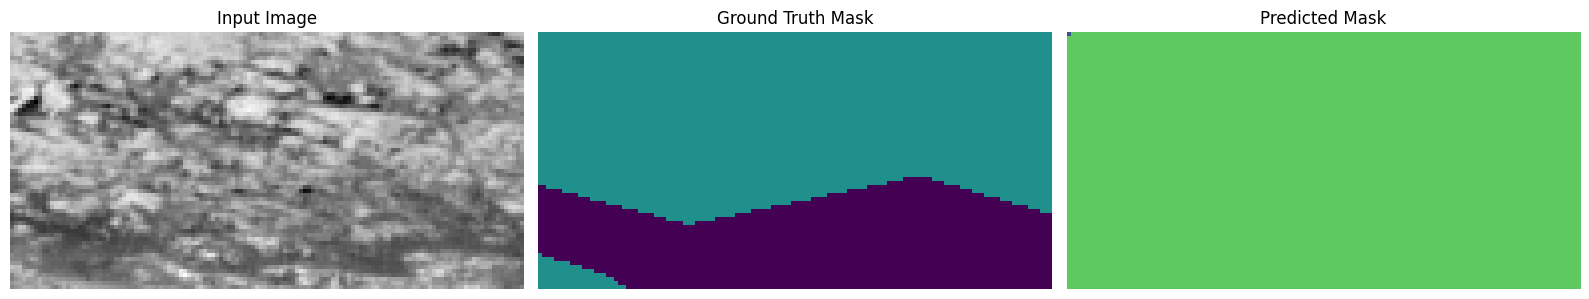

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.6894 - loss: 0.2324 - mean_iou: 0.6548 - val_accuracy: 0.3999 - val_loss: 1.3330 - val_mean_iou: 0.2641
Epoch 22/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.6965 - loss: 0.2167 - mean_iou: 0.6675 - val_accuracy: 0.4207 - val_loss: 0.9938 - val_mean_iou: 0.2891
Epoch 23/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.7011 - loss: 0.2089 - mean_iou: 0.6771 - val_accuracy: 0.5275 - val_loss: 0.8148 - val_mean_iou: 0.4061
Epoch 24/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.7050 - loss: 0.1876 - mean_iou: 0.6836 - val_accuracy: 0.5710 - val_loss: 0.6546 - val_mean_iou: 0.4525
Epoch 25/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.7055 - loss: 0.1834 - mean_iou: 0.6855 - val_accuracy: 0.5367 - val_loss: 0.8226 - val_mean_iou: 0.4191
Epoch 26/1000
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7089 - loss: 0.1702 - mean_iou: 0.6942

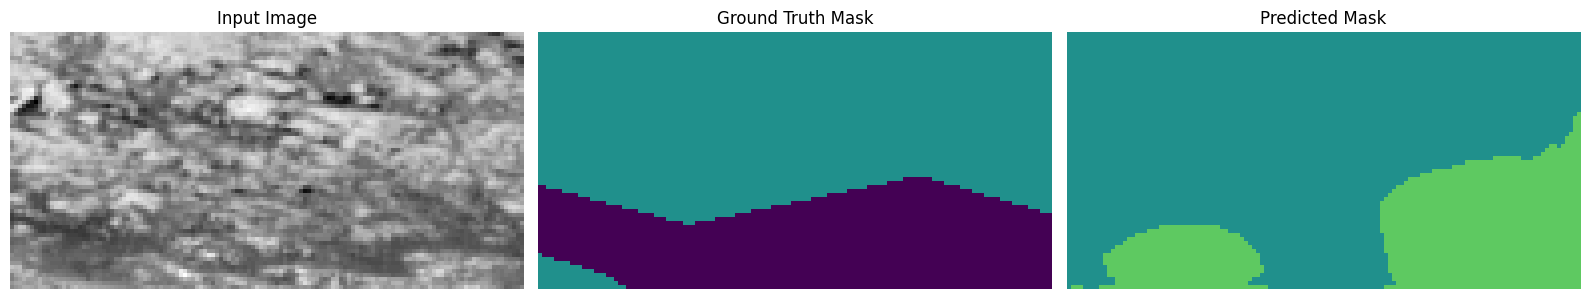

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.7094 - loss: 0.1706 - mean_iou: 0.6929 - val_accuracy: 0.4381 - val_loss: 1.2351 - val_mean_iou: 0.3077
Epoch 27/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.7081 - loss: 0.1698 - mean_iou: 0.6903 - val_accuracy: 0.5945 - val_loss: 0.5516 - val_mean_iou: 0.4871
Epoch 28/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.7149 - loss: 0.1550 - mean_iou: 0.7032 - val_accuracy: 0.6031 - val_loss: 0.5365 - val_mean_iou: 0.4974
Epoch 29/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.7131 - loss: 0.1658 - mean_iou: 0.6993 - val_accuracy: 0.6078 - val_loss: 0.5526 - val_mean_iou: 0.5070
Epoch 30/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.7226 - loss: 0.1298 - mean_iou: 0.7187 - val_accuracy: 0.5932 - val_loss: 0.5889 - val_mean_iou: 0.4796
Epoch 31/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7210 - loss: 0.1344 - mean_iou: 0.7165

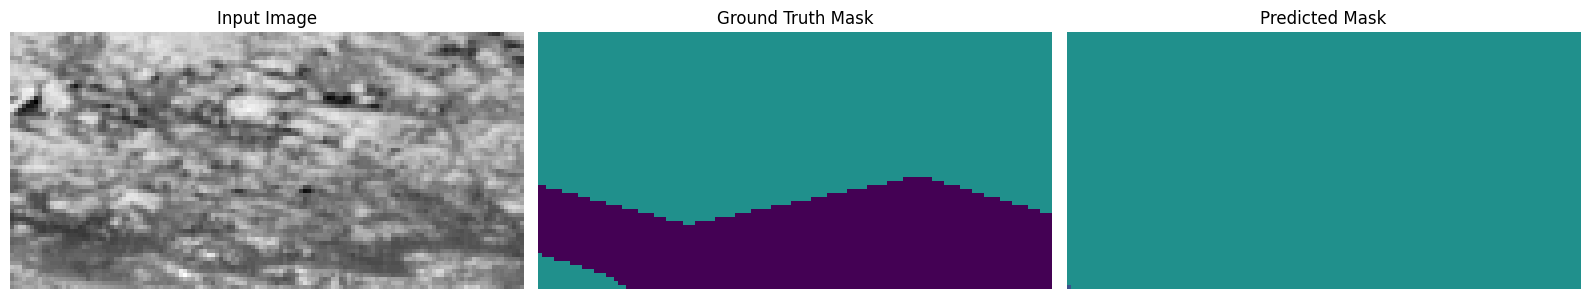

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.7213 - loss: 0.1346 - mean_iou: 0.7159 - val_accuracy: 0.3456 - val_loss: 2.0466 - val_mean_iou: 0.2283
Epoch 32/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.7194 - loss: 0.1409 - mean_iou: 0.7122 - val_accuracy: 0.5629 - val_loss: 0.7545 - val_mean_iou: 0.4525
Epoch 33/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.7183 - loss: 0.1428 - mean_iou: 0.7098 - val_accuracy: 0.5554 - val_loss: 0.7407 - val_mean_iou: 0.4442
Epoch 34/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.7175 - loss: 0.1457 - mean_iou: 0.7084 - val_accuracy: 0.4144 - val_loss: 1.5937 - val_mean_iou: 0.2879
Epoch 35/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.7183 - loss: 0.1440 - mean_iou: 0.7085 - val_accuracy: 0.5343 - val_loss: 1.1321 - val_mean_iou: 0.4175
Epoch 36/1000
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7140 - loss: 0.1478 - mean_iou: 0.7026

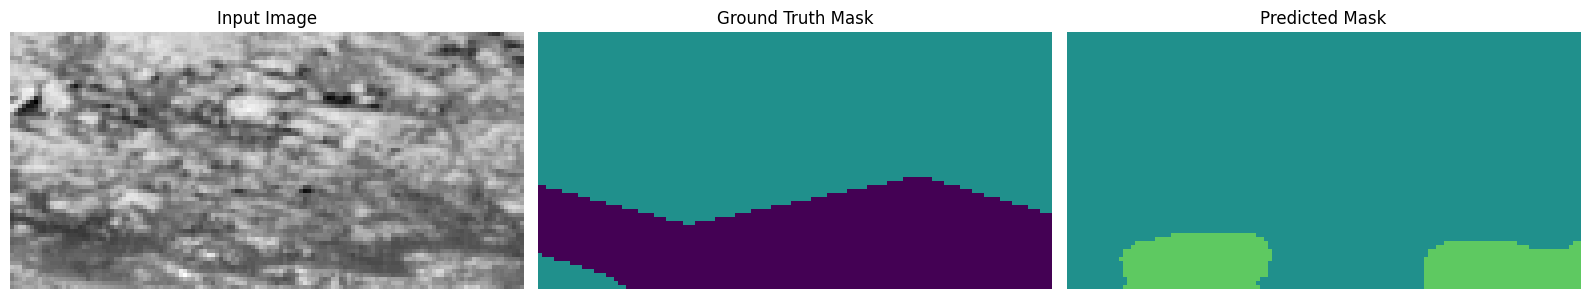

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.7148 - loss: 0.1476 - mean_iou: 0.7018 - val_accuracy: 0.3873 - val_loss: 1.9574 - val_mean_iou: 0.2676
Epoch 37/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.7210 - loss: 0.1329 - mean_iou: 0.7149 - val_accuracy: 0.3926 - val_loss: 1.8211 - val_mean_iou: 0.2149
Epoch 38/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.7174 - loss: 0.1454 - mean_iou: 0.7078 - val_accuracy: 0.5662 - val_loss: 0.8160 - val_mean_iou: 0.4574
Epoch 39/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.7247 - loss: 0.1195 - mean_iou: 0.7224 - val_accuracy: 0.5889 - val_loss: 0.6859 - val_mean_iou: 0.4756
Epoch 40/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.7248 - loss: 0.1157 - mean_iou: 0.7227 - val_accuracy: 0.4885 - val_loss: 1.1095 - val_mean_iou: 0.3633
Epoch 41/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7235 - loss: 0.1226 - mean_iou: 0.7224

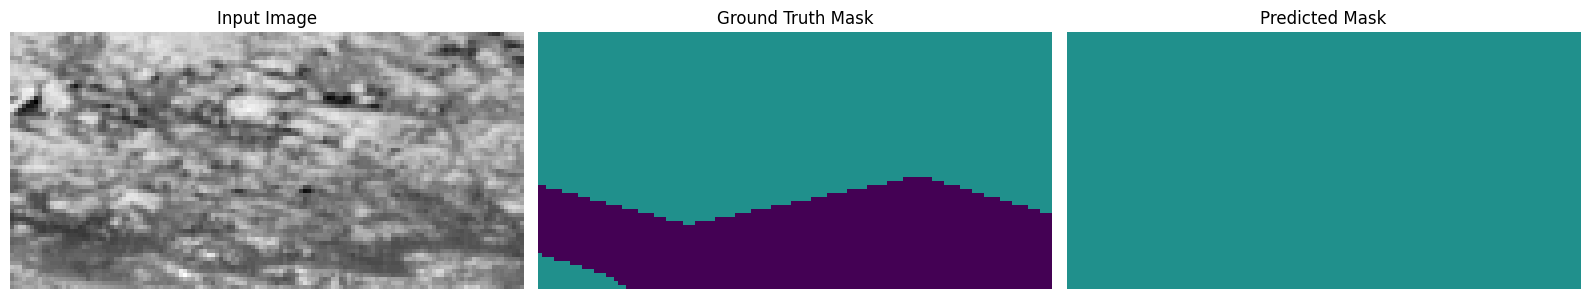

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.7239 - loss: 0.1226 - mean_iou: 0.7218 - val_accuracy: 0.4930 - val_loss: 1.0797 - val_mean_iou: 0.3528
Epoch 42/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.7264 - loss: 0.1105 - mean_iou: 0.7268 - val_accuracy: 0.5824 - val_loss: 0.7743 - val_mean_iou: 0.4568
Epoch 43/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.7281 - loss: 0.1036 - mean_iou: 0.7295 - val_accuracy: 0.5798 - val_loss: 0.7791 - val_mean_iou: 0.4715
Epoch 44/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.7272 - loss: 0.1117 - mean_iou: 0.7276 - val_accuracy: 0.3859 - val_loss: 1.9807 - val_mean_iou: 0.2378
Epoch 45/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.7190 - loss: 0.1340 - mean_iou: 0.7127 - val_accuracy: 0.2891 - val_loss: 3.0182 - val_mean_iou: 0.1438
Epoch 46/1000
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7220 - loss: 0.1259 - mean_iou: 0.7197

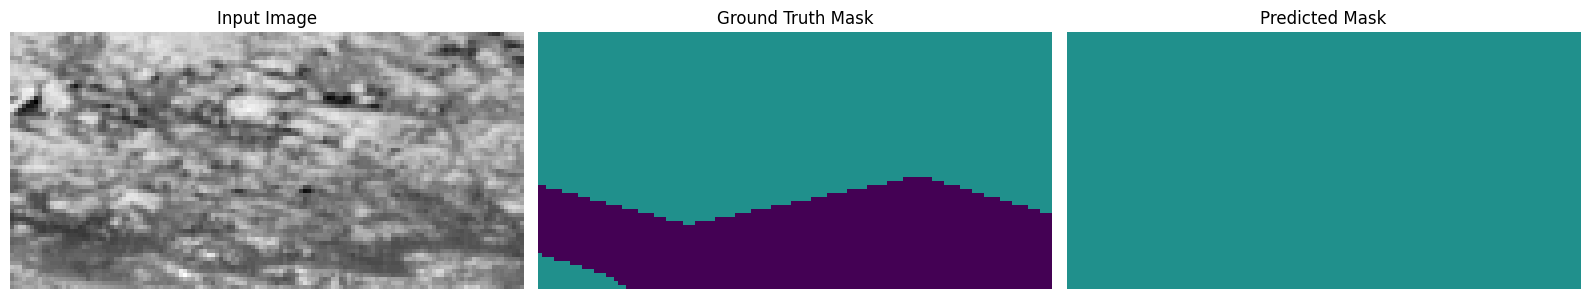

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.7227 - loss: 0.1257 - mean_iou: 0.7187 - val_accuracy: 0.4385 - val_loss: 1.5328 - val_mean_iou: 0.2921
Epoch 47/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.7196 - loss: 0.1281 - mean_iou: 0.7125 - val_accuracy: 0.5849 - val_loss: 0.7263 - val_mean_iou: 0.4746
Epoch 48/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7237 - loss: 0.1185 - mean_iou: 0.7209 - val_accuracy: 0.5391 - val_loss: 0.9691 - val_mean_iou: 0.4267
Epoch 49/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.7284 - loss: 0.1032 - mean_iou: 0.7303 - val_accuracy: 0.5588 - val_loss: 0.7392 - val_mean_iou: 0.4392
Epoch 50/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.7301 - loss: 0.0984 - mean_iou: 0.7331 - val_accuracy: 0.5968 - val_loss: 0.6335 - val_mean_iou: 0.4861
Epoch 51/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7323 - loss: 0.0875 - mean_iou: 0.7393

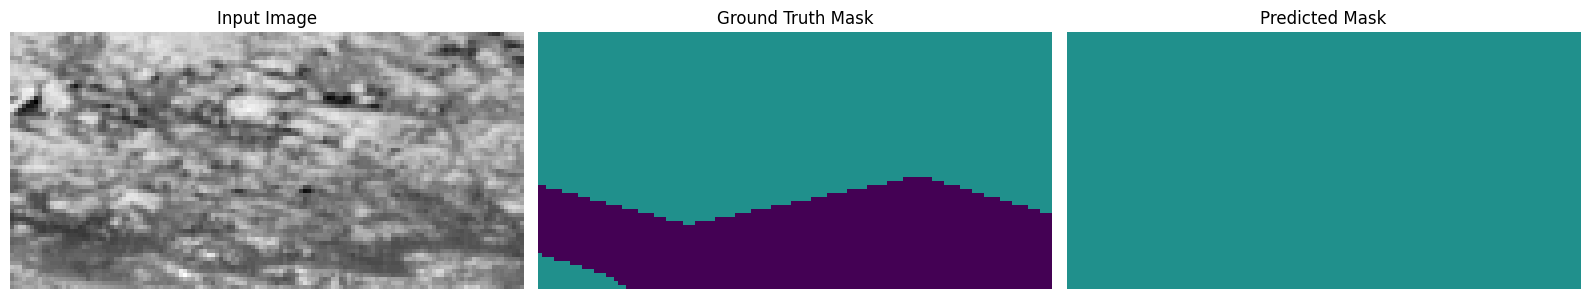

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.7326 - loss: 0.0877 - mean_iou: 0.7387 - val_accuracy: 0.6128 - val_loss: 0.6053 - val_mean_iou: 0.5126
Epoch 52/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7258 - loss: 0.1101 - mean_iou: 0.7239 - val_accuracy: 0.6141 - val_loss: 0.6441 - val_mean_iou: 0.5136
Epoch 53/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.7275 - loss: 0.1081 - mean_iou: 0.7279 - val_accuracy: 0.5551 - val_loss: 0.8306 - val_mean_iou: 0.4427
Epoch 54/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.7281 - loss: 0.1027 - mean_iou: 0.7291 - val_accuracy: 0.5883 - val_loss: 0.6779 - val_mean_iou: 0.4744
Epoch 55/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.7285 - loss: 0.1030 - mean_iou: 0.7297 - val_accuracy: 0.6155 - val_loss: 0.6121 - val_mean_iou: 0.5107
Epoch 56/1000
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7300 - loss: 0.1025 - mean_iou: 0.7359

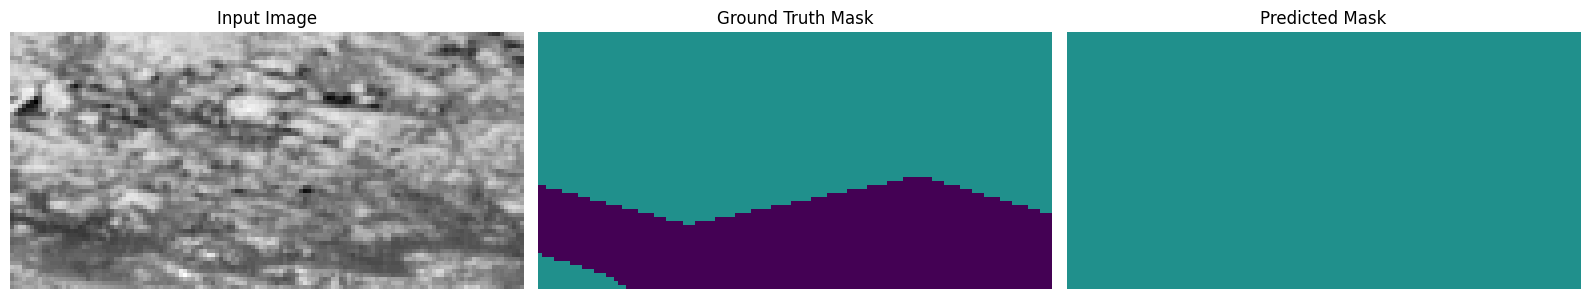

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.7307 - loss: 0.1021 - mean_iou: 0.7349 - val_accuracy: 0.6040 - val_loss: 0.6650 - val_mean_iou: 0.5035
Epoch 57/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.7326 - loss: 0.0883 - mean_iou: 0.7389 - val_accuracy: 0.5674 - val_loss: 0.7909 - val_mean_iou: 0.4613
Epoch 58/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.7339 - loss: 0.0839 - mean_iou: 0.7410 - val_accuracy: 0.5936 - val_loss: 0.7011 - val_mean_iou: 0.4895
Epoch 59/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.7331 - loss: 0.0879 - mean_iou: 0.7398 - val_accuracy: 0.5764 - val_loss: 0.8162 - val_mean_iou: 0.4692
Epoch 60/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.7340 - loss: 0.0827 - mean_iou: 0.7415 - val_accuracy: 0.5945 - val_loss: 0.7044 - val_mean_iou: 0.4904
Epoch 61/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7318 - loss: 0.0869 - mean_iou: 0.7377

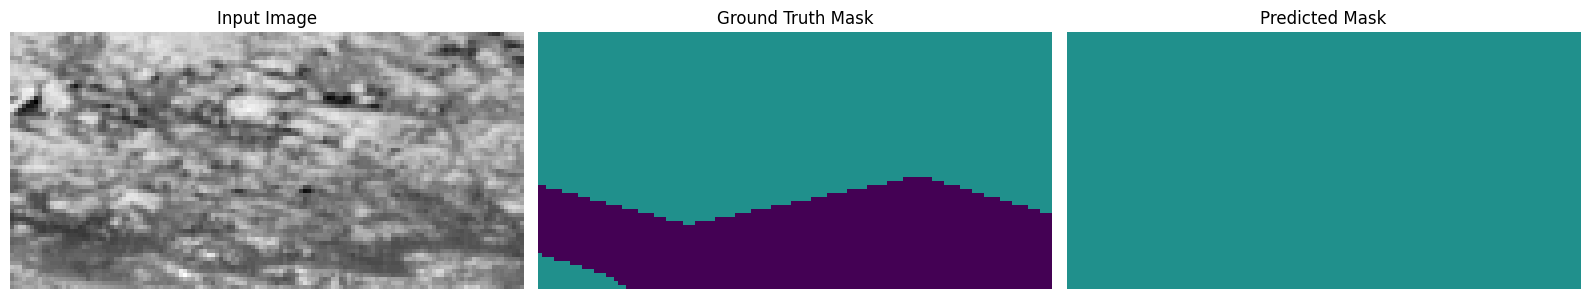

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.7322 - loss: 0.0869 - mean_iou: 0.7372 - val_accuracy: 0.6097 - val_loss: 0.6299 - val_mean_iou: 0.5110
Epoch 62/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.7315 - loss: 0.0957 - mean_iou: 0.7363 - val_accuracy: 0.6053 - val_loss: 0.6768 - val_mean_iou: 0.4936
Epoch 63/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.7326 - loss: 0.0872 - mean_iou: 0.7384 - val_accuracy: 0.6064 - val_loss: 0.6920 - val_mean_iou: 0.5048
Epoch 64/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.7349 - loss: 0.0796 - mean_iou: 0.7434 - val_accuracy: 0.6027 - val_loss: 0.7242 - val_mean_iou: 0.5023
Epoch 65/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.7313 - loss: 0.0914 - mean_iou: 0.7364 - val_accuracy: 0.6152 - val_loss: 0.6462 - val_mean_iou: 0.5156
Epoch 66/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7345 - loss: 0.0839 - mean_iou: 0.7435

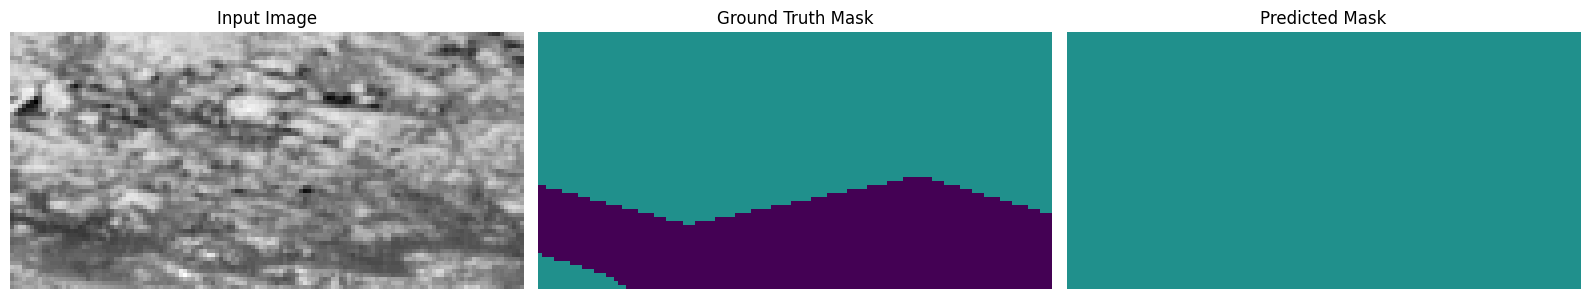

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.7348 - loss: 0.0838 - mean_iou: 0.7430 - val_accuracy: 0.6095 - val_loss: 0.7108 - val_mean_iou: 0.5085
Epoch 67/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.7335 - loss: 0.0817 - mean_iou: 0.7409 - val_accuracy: 0.5725 - val_loss: 0.8839 - val_mean_iou: 0.4618
Epoch 68/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.7306 - loss: 0.0908 - mean_iou: 0.7341 - val_accuracy: 0.4572 - val_loss: 1.6177 - val_mean_iou: 0.3410
Epoch 69/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.7321 - loss: 0.0905 - mean_iou: 0.7374 - val_accuracy: 0.5599 - val_loss: 0.9277 - val_mean_iou: 0.4532
Epoch 70/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.7289 - loss: 0.0977 - mean_iou: 0.7315 - val_accuracy: 0.5751 - val_loss: 0.8639 - val_mean_iou: 0.4613
Epoch 71/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7326 - loss: 0.0860 - mean_iou: 0.7404

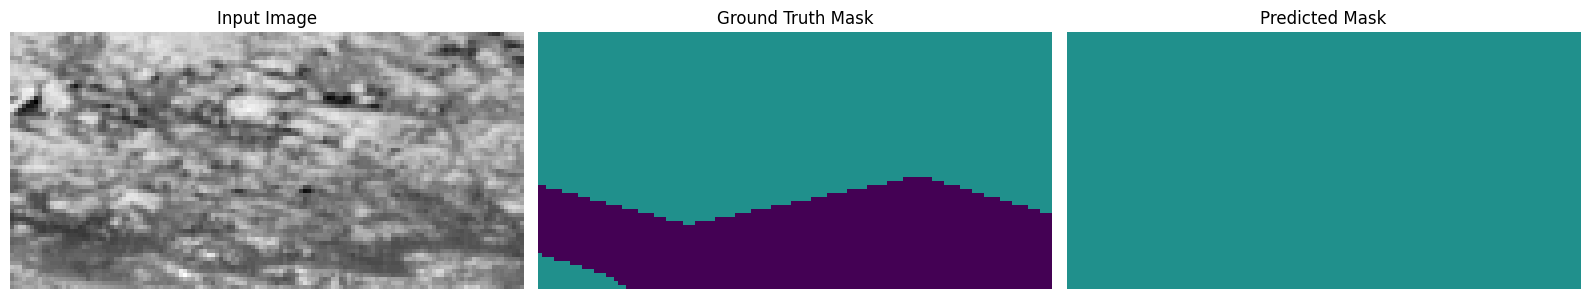

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.7329 - loss: 0.0862 - mean_iou: 0.7398 - val_accuracy: 0.5850 - val_loss: 0.7810 - val_mean_iou: 0.4786
Epoch 72/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.7322 - loss: 0.0882 - mean_iou: 0.7374 - val_accuracy: 0.5952 - val_loss: 0.7839 - val_mean_iou: 0.4880
Epoch 73/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.7333 - loss: 0.0865 - mean_iou: 0.7403 - val_accuracy: 0.5525 - val_loss: 0.9423 - val_mean_iou: 0.4385
Epoch 74/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.7323 - loss: 0.0865 - mean_iou: 0.7378 - val_accuracy: 0.5756 - val_loss: 0.8762 - val_mean_iou: 0.4658
Epoch 75/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.7356 - loss: 0.0774 - mean_iou: 0.7445 - val_accuracy: 0.4749 - val_loss: 1.4047 - val_mean_iou: 0.3657
Epoch 76/1000
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7330 - loss: 0.0832 - mean_iou: 0.7420

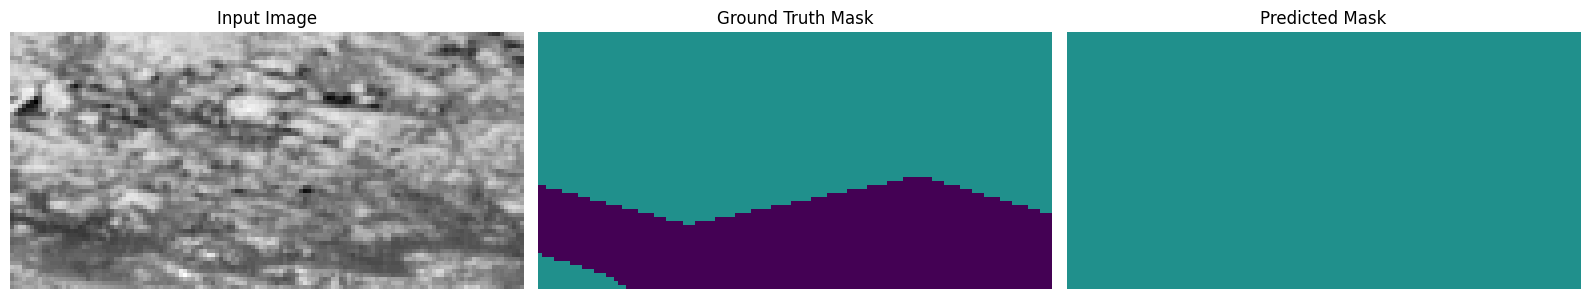

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.7336 - loss: 0.0832 - mean_iou: 0.7410 - val_accuracy: 0.5936 - val_loss: 0.7812 - val_mean_iou: 0.4906
Epoch 77/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.7345 - loss: 0.0820 - mean_iou: 0.7422 - val_accuracy: 0.5979 - val_loss: 0.7391 - val_mean_iou: 0.4936
Epoch 78/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.7354 - loss: 0.0780 - mean_iou: 0.7440 - val_accuracy: 0.5929 - val_loss: 0.7324 - val_mean_iou: 0.4898
Epoch 79/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.7331 - loss: 0.0845 - mean_iou: 0.7392 - val_accuracy: 0.5705 - val_loss: 0.8956 - val_mean_iou: 0.4594
Epoch 80/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.7329 - loss: 0.0879 - mean_iou: 0.7393 - val_accuracy: 0.6032 - val_loss: 0.6941 - val_mean_iou: 0.5000


In [9]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    batch_size=BATCH_SIZE,
    verbose=1
).history

In [10]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241214_135924.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [11]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [12]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_241214_135924.keras


In [16]:
!pip install tta-wrapper

In [26]:
from keras.models import load_model
from tta_wrapper import tta_segmentation

model = load_model('model_MultiResNet_241213_192451_61.84.keras', custom_objects={"MeanIntersectionOverUnion":MeanIntersectionOverUnion})
print(model.input.shape.as_list())
tta_model = tta_segmentation(model, h_flip=True,
                             h_shift=(-5, 5), merge='mean')
y = tta_model.predict(X_test)

TypeError: <class '__main__.MeanIntersectionOverUnion'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'MeanIntersectionOverUnion', 'config': {'num_classes': 5, 'name': 'mean_iou', 'dtype': 'float32', 'ignore_class': None, 'sparse_y_true': True, 'sparse_y_pred': True, 'axis': -1}, 'registered_name': 'MeanIntersectionOverUnion'}.

Exception encountered: MeanIntersectionOverUnion.__init__() got an unexpected keyword argument 'ignore_class'

In [13]:
preds = model.predict(X_test)
predicted_classes = np.argmax(preds, axis=-1)
preds[predicted_classes == 0] = -1  # Ensure preds and predicted_classes have compatible shapes
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step
Predictions shape: (10022, 64, 128)


In [14]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [15]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```